In [1]:
import sys
import os
from tqdm import tqdm
import random
import numpy as np
import math
# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir)

#import simtrain
from simtrain.sim_models_new import User_simmulation_Model, Conditioned_User_simmulation_Model
from simtrain import SETTINGS_POLIMI as SETTINGS
from simtrain import explore_models, process_dat
import simtrain.utils as utils
from simtrain.Dataset import CustomDataset
from simtrain.train import train, train_with_negatives

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import ast

import paths
from os.path import join
import pytorch_warmup as warmup


In [2]:
#num_items = 7
#num_items_per_recom = 2
num_interaction_types = 2
recom_dim = 1
#num_users = 11
#min_inter = 2
#max_inter = 4
state_size = SETTINGS.STATE_SIZE
subset = 20 # make data smaller
experiment_name = "testing3"
num_negatives = 100
conditioned=False
kl_weight=.01

In [3]:
#create dataset from processed data
'''
train_dat, stg = process_dat.load_dat(paths.cw_stages['output_new']['train'], new_data=True)

print(stg)

def convert_string_to_double_list(s):
    return ast.literal_eval(s)

# Apply the custom function
train_dat['item_ids'] = train_dat['item_ids'].apply(convert_string_to_double_list)
train_dat['user_means'] = train_dat['user_means'].apply(convert_string_to_double_list)
train_dat['user_vars_log'] = train_dat['user_vars_log'].apply(convert_string_to_double_list)
train_dat['timestamps'] = train_dat['timestamps'].apply(convert_string_to_double_list)
train_dat['interaction_types'] = train_dat['interaction_types'].apply(convert_string_to_double_list)

print("len: ", len(train_dat))
list_of_dicts = train_dat.to_dict(orient='records')
list_of_dicts = list_of_dicts[:subset]
train_dat.head()
'''

'\ntrain_dat, stg = process_dat.load_dat(paths.cw_stages[\'output_new\'][\'train\'], new_data=True)\n\nprint(stg)\n\ndef convert_string_to_double_list(s):\n    return ast.literal_eval(s)\n\n# Apply the custom function\ntrain_dat[\'item_ids\'] = train_dat[\'item_ids\'].apply(convert_string_to_double_list)\ntrain_dat[\'user_means\'] = train_dat[\'user_means\'].apply(convert_string_to_double_list)\ntrain_dat[\'user_vars_log\'] = train_dat[\'user_vars_log\'].apply(convert_string_to_double_list)\ntrain_dat[\'timestamps\'] = train_dat[\'timestamps\'].apply(convert_string_to_double_list)\ntrain_dat[\'interaction_types\'] = train_dat[\'interaction_types\'].apply(convert_string_to_double_list)\n\nprint("len: ", len(train_dat))\nlist_of_dicts = train_dat.to_dict(orient=\'records\')\nlist_of_dicts = list_of_dicts[:subset]\ntrain_dat.head()\n'

In [4]:

checkpoint = torch.load(join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "data.h5"))
list_of_dicts = checkpoint['data']

In [5]:
'''
def adjust_hidden_dim(data_dict, state_size):
    # just to jumstart experiments should be deleted at the end
    for row in list_of_dicts:
        if row["user_means"] > state_size:
            row["user_means"] = row["user_means"][:state_size]
            row["user_vars_log"] = row["user_vars_log"][:state_size]
        elif row["user_means"] > state_size:


adjust_hidden_dim(list_of_dicts, state_size)
'''

'\ndef adjust_hidden_dim(data_dict, state_size):\n    # just to jumstart experiments should be deleted at the end\n    for row in list_of_dicts:\n        if row["user_means"] > state_size:\n            row["user_means"] = row["user_means"][:state_size]\n            row["user_vars_log"] = row["user_vars_log"][:state_size]\n        elif row["user_means"] > state_size:\n\n\nadjust_hidden_dim(list_of_dicts, state_size)\n'

In [6]:

dataset = CustomDataset(list_of_dicts[:subset]) # [:30]
# Example usage with DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)# can only do batchsize 1

In [7]:
def test_data(dataloader):
    smallest = float("inf")
    biggest = -1
    count_classes = [0 for _ in range(num_interaction_types)]
    for batch in dataloader:
        timestamps, items, labels, means, var, idx = batch
        last = timestamps[0]
        smallest = min(smallest, last)
        biggest = max(biggest, timestamps[-1])
        for i in range(1,len(timestamps)):
            if timestamps[i] <= last:
                print("error, current: ", timestamps[i], "\tlast", last)
        
        for i in range(num_interaction_types):
            for row in labels:
                row=torch.as_tensor(row)
                count = torch.sum(row == i)
                count_classes[i] += count

    smallest, biggest= int(smallest), float(biggest)
    print(smallest), print(biggest)
    for i in range(num_interaction_types):
        print(f"number of interactions of type {i} = {count_classes[i]}")
    return biggest

max_time = test_data(dataloader)

0
69.33333333333333
number of interactions of type 0 = 50918
number of interactions of type 1 = 20214


In [8]:
for batch in dataloader:
    timestamps, items, labels, means, var, idx = batch
    print('Timestamps:', timestamps#, "\n dtype: ", timestamps.dtype
          )
    print('item_recom:', items#, "\n dtype: ", items.dtype
          )
    print('Labels:', labels#, "\n dtype: ", labels.dtype
          )
    print('means:', means#, "\n dtype: ", means.dtype
          )
    print('log_var:', var#, "\n dtype: ", var.dtype
          )
    break
    

Timestamps: [tensor([2.7292], dtype=torch.float64), tensor([11.0833], dtype=torch.float64), tensor([14.4792], dtype=torch.float64), tensor([14.5000], dtype=torch.float64), tensor([14.5208], dtype=torch.float64), tensor([22.2500], dtype=torch.float64)]
item_recom: [[tensor([27]), tensor([226]), tensor([79]), tensor([84]), tensor([162]), tensor([277]), tensor([94]), tensor([284]), tensor([243]), tensor([178]), tensor([84]), tensor([130]), tensor([249]), tensor([199]), tensor([19]), tensor([53]), tensor([290]), tensor([57]), tensor([300]), tensor([229]), tensor([144]), tensor([192]), tensor([66]), tensor([102]), tensor([242]), tensor([300]), tensor([286]), tensor([214]), tensor([188]), tensor([279]), tensor([42]), tensor([222]), tensor([126]), tensor([74]), tensor([49]), tensor([135]), tensor([32]), tensor([84]), tensor([74]), tensor([132]), tensor([162]), tensor([165]), tensor([301]), tensor([161]), tensor([249]), tensor([19]), tensor([144]), tensor([153]), tensor([77]), tensor([199]), t

In [9]:
# parameter dicts
width= 32
user_state_dict = {"model_hyp": {"layer_width": [width, width, width]}}
intensity_state_dict = {"model_hyp": {"user_model_hyp": {"layer_width": [width, width],
                                        "noise": 0},
                        "global_model_hyp": {"layer_width": [width, 3]}}
                            }
interaction_state_dict = {"model_hyp": {"layer_width": [width, width ,width]}
                            }
jump_state_dict = {"model_hyp": {"layer_width": [width, width]}
                        }

In [10]:
import torch.optim as optim

hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, "num_interaction_outcomes": num_interaction_types,
        "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
        "recom_dim":recom_dim, "interaction_model": interaction_state_dict,
        "jump_model": jump_state_dict, "user_params_size": state_size,
        "noise": .01}
model = User_simmulation_Model(hyperparameter_dict)
#model = Conditioned_User_simmulation_Model(hyperparameter_dict)

In [11]:
# load model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "user_model.h5")
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [12]:
num_epochs = 10
warmup_period = len(dataset)
num_steps = num_epochs*len(dataset) -warmup_period
num_iter_til_first_restart = num_steps//2
user_lr = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(model.parameters(), lr=0.01,
                        weight_decay=1e-7)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=5e-5)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


Using device: cpu


In [13]:
utils.print_user_params(dataloader, print_var = True)

means:  [tensor([-0.0650], dtype=torch.float64), tensor([0.0293], dtype=torch.float64), tensor([0.0160], dtype=torch.float64), tensor([0.0170], dtype=torch.float64)]
logvar:  [tensor([-1.3569], dtype=torch.float64), tensor([-0.6309], dtype=torch.float64), tensor([-3.0378], dtype=torch.float64), tensor([-1.1676], dtype=torch.float64)]
means:  [tensor([0.5555], dtype=torch.float64), tensor([-0.5281], dtype=torch.float64), tensor([-0.4462], dtype=torch.float64), tensor([-0.5223], dtype=torch.float64)]
logvar:  [tensor([-2.9949], dtype=torch.float64), tensor([-1.3232], dtype=torch.float64), tensor([-2.9254], dtype=torch.float64), tensor([-1.1151], dtype=torch.float64)]
means:  [tensor([0.0046], dtype=torch.float64), tensor([0.1227], dtype=torch.float64), tensor([-0.2567], dtype=torch.float64), tensor([0.1705], dtype=torch.float64)]
logvar:  [tensor([-3.0190], dtype=torch.float64), tensor([-2.8460], dtype=torch.float64), tensor([-4.4657], dtype=torch.float64), tensor([-4.9160], dtype=torch.

: 

In [14]:
# no negative samples
with torch.autograd.set_detect_anomaly(True):
        train(model, dataloader=dataloader, num_epochs=num_epochs, device=device, loss_func=utils.loss_func, 
                loss_func_kl=utils.kl_loss, kl_weight=kl_weight, user_lr=user_lr, conditioned=conditioned,
                optimizer=optimizer, lr_scheduler=lr_scheduler, num_classes=num_interaction_types, 
                logger=utils.logging_func, warmup_period=warmup_period, intensity_loss_func=utils.square_intensity_loss,
                state_size=state_size,max_time=max_time, log_step_size=1, warmup_scheduler = warmup_scheduler,
                )


  0%|          | 0/10 [00:00<?, ?it/s]/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


loss_all: 83.185 	loss_base: 10.408 	loss_kl: 11.211 	loss_intensity:  61.566 	log of the loss: 1.92
loss_all: 177.653 	loss_base: 20.356 	loss_kl: 33.775 	loss_intensity:  123.523 	log of the loss: 2.25
loss_all: 329.329 	loss_base: 66.809 	loss_kl: 77.167 	loss_intensity:  185.353 	log of the loss: 2.52
loss_all: 421.758 	loss_base: 78.782 	loss_kl: 105.552 	loss_intensity:  237.423 	log of the loss: 2.63


In [ ]:
adsaf 

NameError: name 'adsaf' is not defined

In [ ]:
train_with_negatives(model, dataloader=dataloader, num_epochs=num_epochs, device=device, 
                loss_func=utils.loss_func, loss_func_kl=utils.kl_loss, kl_weight=kl_weight, 
                user_lr=user_lr, optimizer=optimizer, lr_scheduler=lr_scheduler, 
                num_classes=num_interaction_types, logger=utils.logging_func,
                warmup_period=warmup_period, intensity_loss_func=utils.log_loss,
                state_size=state_size,max_time=max_time, log_step_size=1, warmup_scheduler = warmup_scheduler,
                num_negatives=num_negatives, positive_examples_weight=5,conditioned=conditioned,
                )

  0%|          | 0/10 [00:00<?, ?it/s]/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
 10%|█         | 1/10 [03:36<32:32, 216.99s/it]

loss_all: 6022.002 	loss_base: 1665.032 	loss_kl: 1009.140 	loss_intensity:  3347.830 	log of the loss: 3.78


 20%|██        | 2/10 [07:35<30:35, 229.43s/it]

loss_all: 5316.963 	loss_base: 1665.079 	loss_kl: 976.702 	loss_intensity:  2675.182 	log of the loss: 3.73


 30%|███       | 3/10 [11:40<27:37, 236.82s/it]

loss_all: 5213.752 	loss_base: 1665.184 	loss_kl: 948.971 	loss_intensity:  2599.597 	log of the loss: 3.72


 30%|███       | 3/10 [12:24<28:58, 248.32s/it]


KeyboardInterrupt: 

In [ ]:
utils.print_user_params(dataloader, print_var = True)

means:  [tensor([0.0020], dtype=torch.float64), tensor([0.0003], dtype=torch.float64), tensor([-0.0003], dtype=torch.float64)]
logvar:  [tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64)]
means:  [tensor([-0.0076], dtype=torch.float64), tensor([-0.0022], dtype=torch.float64), tensor([0.0018], dtype=torch.float64)]
logvar:  [tensor([-0.5774], dtype=torch.float64), tensor([-0.5774], dtype=torch.float64), tensor([-0.5774], dtype=torch.float64)]
means:  [tensor([0.0010], dtype=torch.float64), tensor([0.0013], dtype=torch.float64), tensor([-0.0005], dtype=torch.float64)]
logvar:  [tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64)]
means:  [tensor([-0.0024], dtype=torch.float64), tensor([0.1395], dtype=torch.float64), tensor([-0.1428], dtype=torch.float64)]
logvar:  [tensor([-0.4619], dtype=torch.float64), tensor([-0.4619], dtype=torch.float64), tensor([-0

In [ ]:
#save model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "user_model.h5")

torch.save(model.state_dict(), path)

In [ ]:
# save data(changes during training)
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "data.h5")
torch.save({
    'data': dataloader.dataset.data,
}, path,
)


loaded sim_models
total visits for user 6
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5020]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5026]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.4968]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5004]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.4659]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.


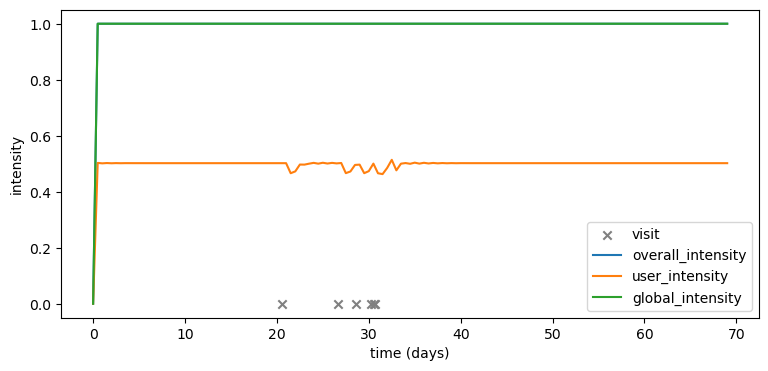

In [ ]:
# conditioned square continouous state + state_int new formulas
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

total visits for user 6
overall_intensity:  tensor([[0.4791]]) 	user_intensity:  tensor([[0.4861]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4793]]) 	user_intensity:  tensor([[0.4862]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4425]]) 	user_intensity:  tensor([[0.4616]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4629]]) 	user_intensity:  tensor([[0.4753]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4884]]) 	user_intensity:  tensor([[0.4922]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


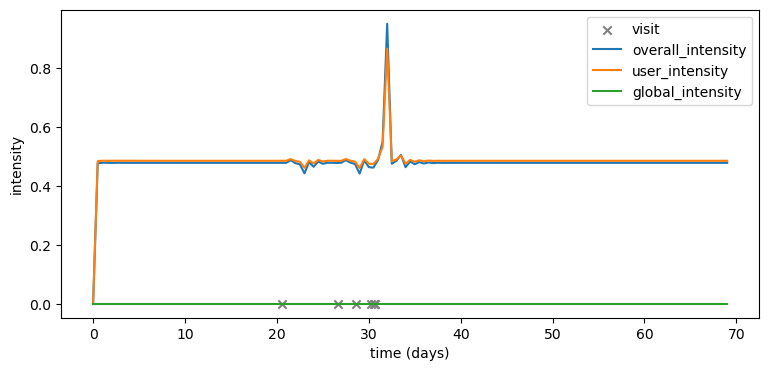

In [ ]:
# conditioned square continouous state + state_int
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[0.4997]]) 	user_intensity:  tensor([[0.4998]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4988]]) 	user_intensity:  tensor([[0.4992]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4539]]) 	user_intensity:  tensor([[0.4692]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4550]]) 	user_intensity:  tensor([[0.4699]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4708]]) 	user_intensity:  tensor([[0.4805]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


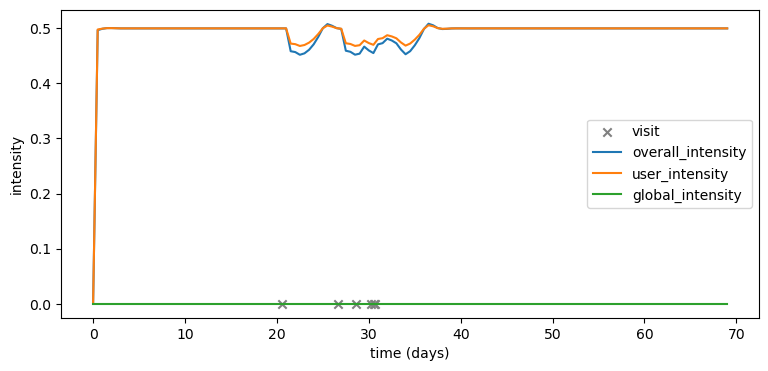

In [ ]:
# conditioned square continouous state
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

total visits for user 6
overall_intensity:  tensor([[0.4913]]) 	user_intensity:  tensor([[0.4942]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5027]]) 	user_intensity:  tensor([[0.5018]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5085]]) 	user_intensity:  tensor([[0.5056]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5214]]) 	user_intensity:  tensor([[0.5143]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5335]]) 	user_intensity:  tensor([[0.5223]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


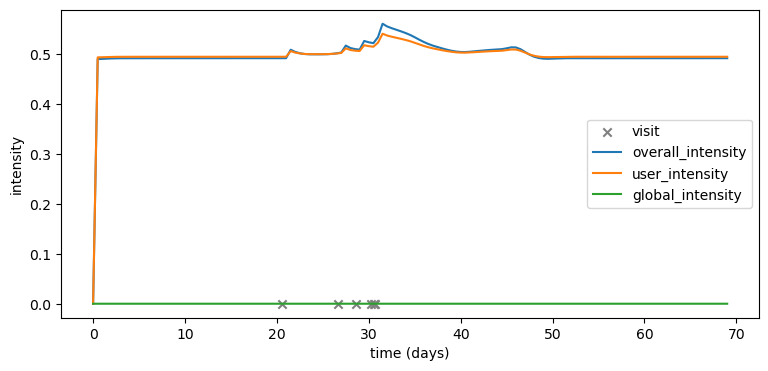

In [ ]:
# conditioned negative
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

total visits for user 7
overall_intensity:  tensor([[0.4873]]) 	user_intensity:  tensor([[0.4915]]) 	global_intensity:  tensor([4.8434e-29]) 	 before a recommendation.
overall_intensity:  tensor([[0.4734]]) 	user_intensity:  tensor([[0.4822]]) 	global_intensity:  tensor([4.7692e-39]) 	 before a recommendation.
overall_intensity:  tensor([[0.4891]]) 	user_intensity:  tensor([[0.4927]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4924]]) 	user_intensity:  tensor([[0.4950]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


overall_intensity:  tensor([[0.4925]]) 	user_intensity:  tensor([[0.4950]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4820]]) 	user_intensity:  tensor([[0.4880]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


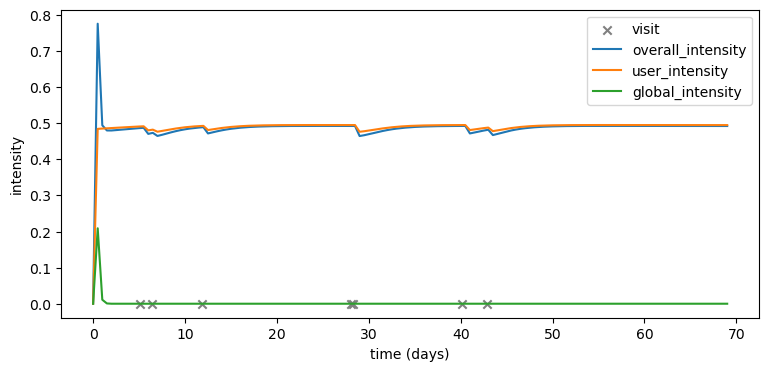

In [ ]:
# conditioned_square
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=4, conditioned=conditioned, increment=.5)

total visits for user 7
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5096]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.6996]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.6718]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5188]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5774]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.7162]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.


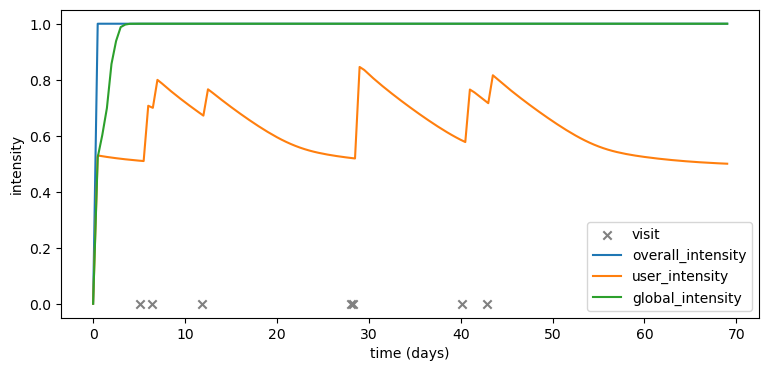

In [ ]:
# negative sampling  larger intervals
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=4, conditioned=False, increment=.5)

total visits for user 7
overall_intensity:  tensor([[0.4996]]) 	user_intensity:  tensor([[0.4997]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4962]]) 	user_intensity:  tensor([[0.4975]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5002]]) 	user_intensity:  tensor([[0.5001]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5002]]) 	user_intensity:  tensor([[0.5001]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4761]]) 	user_intensity:  tensor([[0.4841]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5002]]) 	user_intensity:  tensor([[0.5001]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4948]]) 	user_intensity:  tensor([[0.4965]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


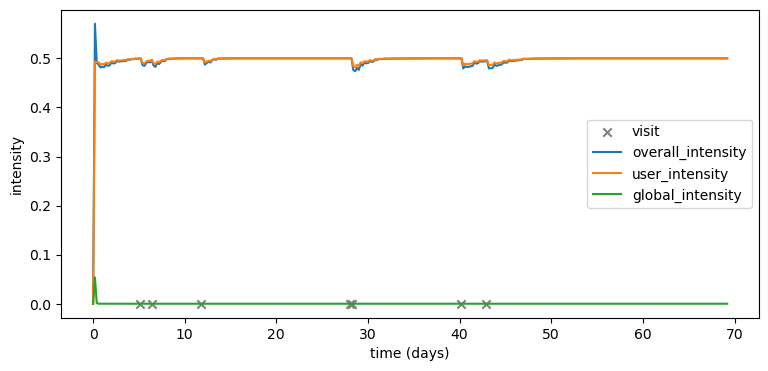

In [ ]:
# square  larger intervals train longer
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=4, conditioned=False, increment=.2)

loaded sim_models
total visits for user 12
overall_intensity:  tensor([[0.4660]]) 	user_intensity:  tensor([[0.4773]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4668]]) 	user_intensity:  tensor([[0.4779]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.9060]]) 	user_intensity:  tensor([[0.8106]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.9868]]) 	user_intensity:  tensor([[0.9322]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[1.]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[1.]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[1.]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


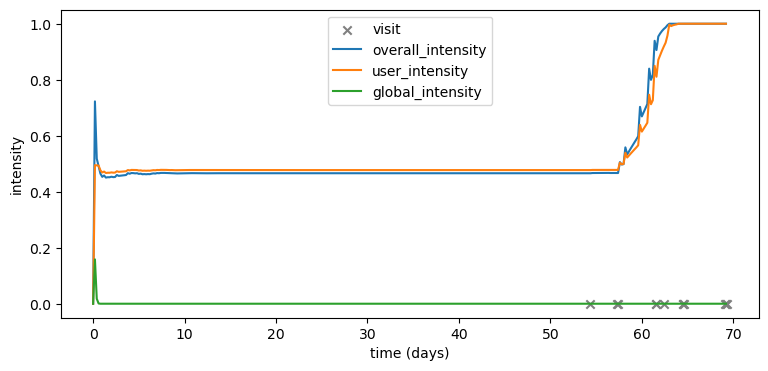

In [ ]:
# square  larger intervals
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=1, conditioned=False, increment=.2)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.


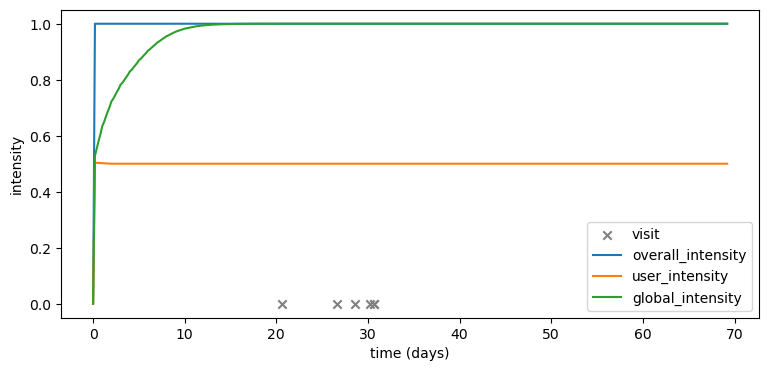

In [ ]:
# square continuous state integral
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=False)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


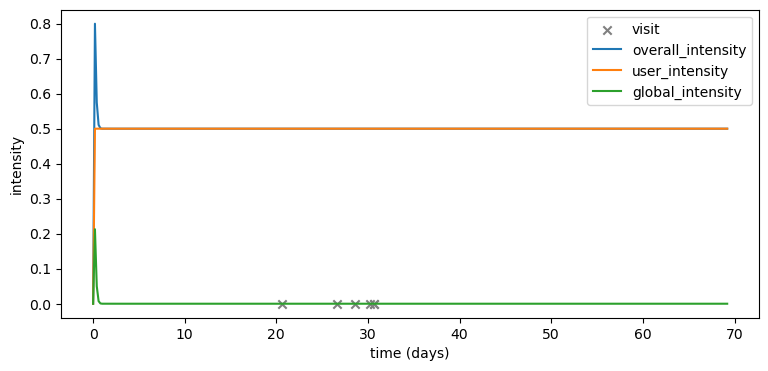

In [ ]:
# negative conditioned
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=True)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


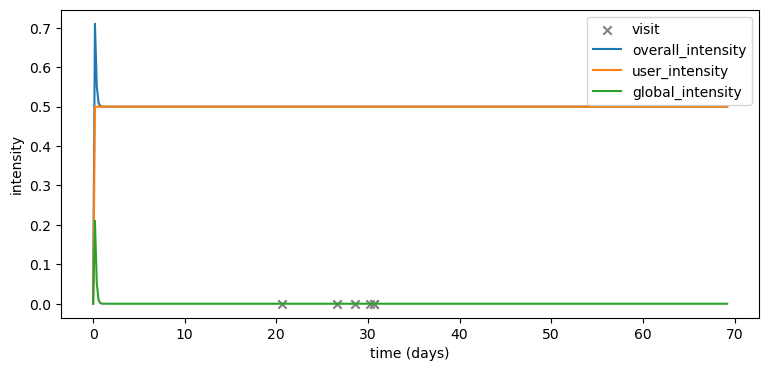

In [ ]:
# square conditioned
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=True)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


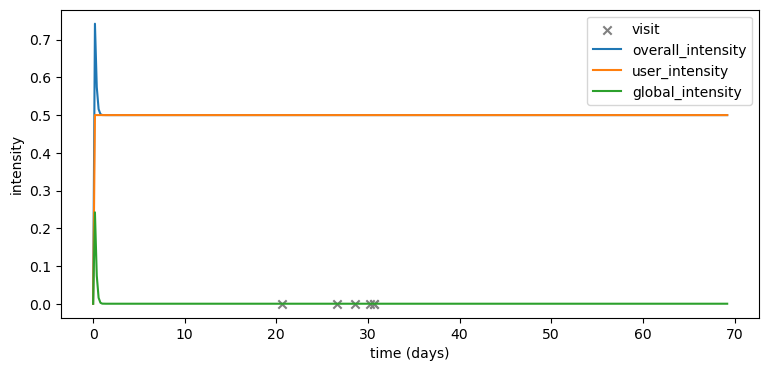

In [ ]:
# square
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2)

total visits for user 12
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


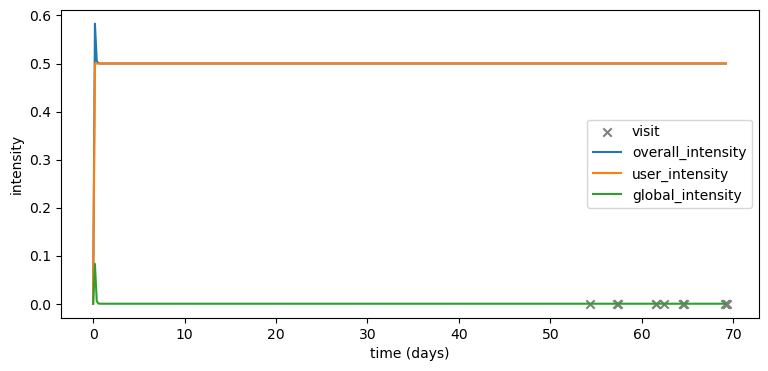

In [ ]:
#negative
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=1)